# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8682
Epoch 1/200, Iteration 2/12, Loss: 0.7882
Epoch 1/200, Iteration 3/12, Loss: 0.8231
Epoch 1/200, Iteration 4/12, Loss: 0.8731
Epoch 1/200, Iteration 5/12, Loss: 0.7801
Epoch 1/200, Iteration 6/12, Loss: 0.7494
Epoch 1/200, Iteration 7/12, Loss: 0.6669
Epoch 1/200, Iteration 8/12, Loss: 0.7418
Epoch 1/200, Iteration 9/12, Loss: 0.7393
Epoch 1/200, Iteration 10/12, Loss: 0.7634
Epoch 1/200, Iteration 11/12, Loss: 0.8008
Epoch 1/200, Iteration 12/12, Loss: 0.6667
Epoch 1/200, Iteration 13/12, Loss: 0.7637
Train Error: 
 Accuracy: 47.25%, Avg loss: 0.708063, MRE: 0.631559, MAE: 0.098091 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.638722, MRE: 0.494585, MAE: 0.086663 

Epoch 2/200, Iteration 1/12, Loss: 0.7552
Epoch 2/200, Iteration 2/12, Loss: 0.6262
Epoch 2/200, Iteration 3/12, Loss: 0.7390
Epoch 2/200, Iteration 4/12, Loss: 0.6711
Epoch 2/200, Iteration 5/12, Loss: 0.7470
Epoch 2/200, Iteration 6/12, Loss: 0.5918
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 62.75%, Avg loss: 0.213146, MRE: 0.186400, MAE: 0.025783 

Test Error: 
 Accuracy: 70.0%, Avg loss: 0.189457, MRE: 0.150051, MAE: 0.022249 

Epoch 13/200, Iteration 1/12, Loss: 0.1830
Epoch 13/200, Iteration 2/12, Loss: 0.2360
Epoch 13/200, Iteration 3/12, Loss: 0.2198
Epoch 13/200, Iteration 4/12, Loss: 0.2038
Epoch 13/200, Iteration 5/12, Loss: 0.1733
Epoch 13/200, Iteration 6/12, Loss: 0.1915
Epoch 13/200, Iteration 7/12, Loss: 0.2124
Epoch 13/200, Iteration 8/12, Loss: 0.2126
Epoch 13/200, Iteration 9/12, Loss: 0.2878
Epoch 13/200, Iteration 10/12, Loss: 0.2130
Epoch 13/200, Iteration 11/12, Loss: 0.1948
Epoch 13/200, Iteration 12/12, Loss: 0.2073
Epoch 13/200, Iteration 13/12, Loss: 0.2679
Train Error: 
 Accuracy: 64.12%, Avg loss: 0.211310, MRE: 0.184757, MAE: 0.025511 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.188687, MRE: 0.149833, MAE: 0.022050 

Epoch 14/200, Iteration 1/12, Loss: 0.2094
Epoch 14/200, Iteration 2/12, Loss: 0.2125
Epoch 14/200, Itera

Train Error: 
 Accuracy: 64.0%, Avg loss: 0.206174, MRE: 0.174648, MAE: 0.024840 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.179642, MRE: 0.141835, MAE: 0.020959 

Epoch 25/200, Iteration 1/12, Loss: 0.1951
Epoch 25/200, Iteration 2/12, Loss: 0.1839
Epoch 25/200, Iteration 3/12, Loss: 0.2008
Epoch 25/200, Iteration 4/12, Loss: 0.1857
Epoch 25/200, Iteration 5/12, Loss: 0.1749
Epoch 25/200, Iteration 6/12, Loss: 0.2152
Epoch 25/200, Iteration 7/12, Loss: 0.1629
Epoch 25/200, Iteration 8/12, Loss: 0.2099
Epoch 25/200, Iteration 9/12, Loss: 0.2460
Epoch 25/200, Iteration 10/12, Loss: 0.1976
Epoch 25/200, Iteration 11/12, Loss: 0.2555
Epoch 25/200, Iteration 12/12, Loss: 0.2062
Epoch 25/200, Iteration 13/12, Loss: 0.1718
Train Error: 
 Accuracy: 63.25%, Avg loss: 0.200323, MRE: 0.173546, MAE: 0.023992 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.177853, MRE: 0.139532, MAE: 0.020735 

Epoch 26/200, Iteration 1/12, Loss: 0.2007
Epoch 26/200, Iteration 2/12, Loss: 0.2221
Epoch 26/200, Iterat

Epoch 37/200, Iteration 8/12, Loss: 0.1988
Epoch 37/200, Iteration 9/12, Loss: 0.1824
Epoch 37/200, Iteration 10/12, Loss: 0.1898
Epoch 37/200, Iteration 11/12, Loss: 0.1868
Epoch 37/200, Iteration 12/12, Loss: 0.2119
Epoch 37/200, Iteration 13/12, Loss: 0.1420
Train Error: 
 Accuracy: 66.0%, Avg loss: 0.186749, MRE: 0.158981, MAE: 0.022369 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.165231, MRE: 0.128592, MAE: 0.019215 

Epoch 38/200, Iteration 1/12, Loss: 0.1758
Epoch 38/200, Iteration 2/12, Loss: 0.1928
Epoch 38/200, Iteration 3/12, Loss: 0.1981
Epoch 38/200, Iteration 4/12, Loss: 0.1931
Epoch 38/200, Iteration 5/12, Loss: 0.2185
Epoch 38/200, Iteration 6/12, Loss: 0.2190
Epoch 38/200, Iteration 7/12, Loss: 0.1930
Epoch 38/200, Iteration 8/12, Loss: 0.1863
Epoch 38/200, Iteration 9/12, Loss: 0.1697
Epoch 38/200, Iteration 10/12, Loss: 0.1997
Epoch 38/200, Iteration 11/12, Loss: 0.1536
Epoch 38/200, Iteration 12/12, Loss: 0.1473
Epoch 38/200, Iteration 13/12, Loss: 0.2015
Train Erro

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.153667, MRE: 0.117722, MAE: 0.017976 

Epoch 49/200, Iteration 1/12, Loss: 0.1611
Epoch 49/200, Iteration 2/12, Loss: 0.1562
Epoch 49/200, Iteration 3/12, Loss: 0.1516
Epoch 49/200, Iteration 4/12, Loss: 0.1552
Epoch 49/200, Iteration 5/12, Loss: 0.1785
Epoch 49/200, Iteration 6/12, Loss: 0.2029
Epoch 49/200, Iteration 7/12, Loss: 0.1711
Epoch 49/200, Iteration 8/12, Loss: 0.1661
Epoch 49/200, Iteration 9/12, Loss: 0.1631
Epoch 49/200, Iteration 10/12, Loss: 0.1772
Epoch 49/200, Iteration 11/12, Loss: 0.2173
Epoch 49/200, Iteration 12/12, Loss: 0.2027
Epoch 49/200, Iteration 13/12, Loss: 0.1632
Train Error: 
 Accuracy: 70.0%, Avg loss: 0.172903, MRE: 0.145745, MAE: 0.020733 

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.152588, MRE: 0.116739, MAE: 0.017956 

Epoch 50/200, Iteration 1/12, Loss: 0.1781
Epoch 50/200, Iteration 2/12, Loss: 0.1689
Epoch 50/200, Iteration 3/12, Loss: 0.1979
Epoch 50/200, Iteration 4/12, Loss: 0.1437
Epoch 50/200, Iter

Epoch 61/200, Iteration 11/12, Loss: 0.1437
Epoch 61/200, Iteration 12/12, Loss: 0.1283
Epoch 61/200, Iteration 13/12, Loss: 0.1829
Train Error: 
 Accuracy: 69.75%, Avg loss: 0.155956, MRE: 0.125417, MAE: 0.018759 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.134820, MRE: 0.100119, MAE: 0.015965 

Epoch 62/200, Iteration 1/12, Loss: 0.1507
Epoch 62/200, Iteration 2/12, Loss: 0.1739
Epoch 62/200, Iteration 3/12, Loss: 0.1643
Epoch 62/200, Iteration 4/12, Loss: 0.1263
Epoch 62/200, Iteration 5/12, Loss: 0.1651
Epoch 62/200, Iteration 6/12, Loss: 0.1643
Epoch 62/200, Iteration 7/12, Loss: 0.1739
Epoch 62/200, Iteration 8/12, Loss: 0.1559
Epoch 62/200, Iteration 9/12, Loss: 0.1315
Epoch 62/200, Iteration 10/12, Loss: 0.1471
Epoch 62/200, Iteration 11/12, Loss: 0.1859
Epoch 62/200, Iteration 12/12, Loss: 0.1379
Epoch 62/200, Iteration 13/12, Loss: 0.1426
Train Error: 
 Accuracy: 71.25%, Avg loss: 0.154767, MRE: 0.124828, MAE: 0.018655 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.134999, MRE:

Train Error: 
 Accuracy: 75.62%, Avg loss: 0.134577, MRE: 0.102962, MAE: 0.016468 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.119809, MRE: 0.082928, MAE: 0.014473 

Epoch 74/200, Iteration 1/12, Loss: 0.1305
Epoch 74/200, Iteration 2/12, Loss: 0.1456
Epoch 74/200, Iteration 3/12, Loss: 0.1374
Epoch 74/200, Iteration 4/12, Loss: 0.1131
Epoch 74/200, Iteration 5/12, Loss: 0.1272
Epoch 74/200, Iteration 6/12, Loss: 0.1452
Epoch 74/200, Iteration 7/12, Loss: 0.1163
Epoch 74/200, Iteration 8/12, Loss: 0.1052
Epoch 74/200, Iteration 9/12, Loss: 0.1471
Epoch 74/200, Iteration 10/12, Loss: 0.1318
Epoch 74/200, Iteration 11/12, Loss: 0.1711
Epoch 74/200, Iteration 12/12, Loss: 0.1387
Epoch 74/200, Iteration 13/12, Loss: 0.1641
Train Error: 
 Accuracy: 78.0%, Avg loss: 0.134679, MRE: 0.102562, MAE: 0.016427 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.118325, MRE: 0.081204, MAE: 0.014284 

Epoch 75/200, Iteration 1/12, Loss: 0.1542
Epoch 75/200, Iteration 2/12, Loss: 0.1099
Epoch 75/200, Iterat

Epoch 85/200, Iteration 8/12, Loss: 0.0997
Epoch 85/200, Iteration 9/12, Loss: 0.1202
Epoch 85/200, Iteration 10/12, Loss: 0.1154
Epoch 85/200, Iteration 11/12, Loss: 0.0973
Epoch 85/200, Iteration 12/12, Loss: 0.1019
Epoch 85/200, Iteration 13/12, Loss: 0.1219
Train Error: 
 Accuracy: 79.75%, Avg loss: 0.114847, MRE: 0.081573, MAE: 0.014297 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.104666, MRE: 0.068684, MAE: 0.012965 

Epoch 86/200, Iteration 1/12, Loss: 0.1013
Epoch 86/200, Iteration 2/12, Loss: 0.1062
Epoch 86/200, Iteration 3/12, Loss: 0.1174
Epoch 86/200, Iteration 4/12, Loss: 0.1171
Epoch 86/200, Iteration 5/12, Loss: 0.1128
Epoch 86/200, Iteration 6/12, Loss: 0.1472
Epoch 86/200, Iteration 7/12, Loss: 0.1138
Epoch 86/200, Iteration 8/12, Loss: 0.1198
Epoch 86/200, Iteration 9/12, Loss: 0.1006
Epoch 86/200, Iteration 10/12, Loss: 0.1244
Epoch 86/200, Iteration 11/12, Loss: 0.1266
Epoch 86/200, Iteration 12/12, Loss: 0.0963
Epoch 86/200, Iteration 13/12, Loss: 0.1109
Train Err

Train Error: 
 Accuracy: 86.12%, Avg loss: 0.104054, MRE: 0.071509, MAE: 0.012975 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.090661, MRE: 0.060891, MAE: 0.011348 

Epoch 97/200, Iteration 1/12, Loss: 0.0709
Epoch 97/200, Iteration 2/12, Loss: 0.1324
Epoch 97/200, Iteration 3/12, Loss: 0.0688
Epoch 97/200, Iteration 4/12, Loss: 0.1194
Epoch 97/200, Iteration 5/12, Loss: 0.1238
Epoch 97/200, Iteration 6/12, Loss: 0.0971
Epoch 97/200, Iteration 7/12, Loss: 0.0921
Epoch 97/200, Iteration 8/12, Loss: 0.1156
Epoch 97/200, Iteration 9/12, Loss: 0.0726
Epoch 97/200, Iteration 10/12, Loss: 0.1210
Epoch 97/200, Iteration 11/12, Loss: 0.1158
Epoch 97/200, Iteration 12/12, Loss: 0.0989
Epoch 97/200, Iteration 13/12, Loss: 0.0986
Train Error: 
 Accuracy: 82.88%, Avg loss: 0.100948, MRE: 0.071652, MAE: 0.012679 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.089404, MRE: 0.058159, MAE: 0.011330 

Epoch 98/200, Iteration 1/12, Loss: 0.0808
Epoch 98/200, Iteration 2/12, Loss: 0.0980
Epoch 98/200, Itera

Train Error: 
 Accuracy: 80.12%, Avg loss: 0.102656, MRE: 0.073428, MAE: 0.013159 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.090551, MRE: 0.059379, MAE: 0.011540 

Epoch 109/200, Iteration 1/12, Loss: 0.1157
Epoch 109/200, Iteration 2/12, Loss: 0.0784
Epoch 109/200, Iteration 3/12, Loss: 0.1008
Epoch 109/200, Iteration 4/12, Loss: 0.1000
Epoch 109/200, Iteration 5/12, Loss: 0.0835
Epoch 109/200, Iteration 6/12, Loss: 0.0920
Epoch 109/200, Iteration 7/12, Loss: 0.1110
Epoch 109/200, Iteration 8/12, Loss: 0.0773
Epoch 109/200, Iteration 9/12, Loss: 0.0929
Epoch 109/200, Iteration 10/12, Loss: 0.0866
Epoch 109/200, Iteration 11/12, Loss: 0.1139
Epoch 109/200, Iteration 12/12, Loss: 0.0848
Epoch 109/200, Iteration 13/12, Loss: 0.0551
Train Error: 
 Accuracy: 89.38%, Avg loss: 0.089285, MRE: 0.060436, MAE: 0.011331 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.080544, MRE: 0.052673, MAE: 0.010279 

Epoch 110/200, Iteration 1/12, Loss: 0.0934
Epoch 110/200, Iteration 2/12, Loss: 0.0771
Epoc

Epoch 121/200, Iteration 3/12, Loss: 0.0986
Epoch 121/200, Iteration 4/12, Loss: 0.1144
Epoch 121/200, Iteration 5/12, Loss: 0.0904
Epoch 121/200, Iteration 6/12, Loss: 0.0803
Epoch 121/200, Iteration 7/12, Loss: 0.0803
Epoch 121/200, Iteration 8/12, Loss: 0.1007
Epoch 121/200, Iteration 9/12, Loss: 0.0798
Epoch 121/200, Iteration 10/12, Loss: 0.0946
Epoch 121/200, Iteration 11/12, Loss: 0.0643
Epoch 121/200, Iteration 12/12, Loss: 0.0892
Epoch 121/200, Iteration 13/12, Loss: 0.0494
Train Error: 
 Accuracy: 90.25%, Avg loss: 0.083001, MRE: 0.056064, MAE: 0.010608 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.072644, MRE: 0.047122, MAE: 0.009341 

Epoch 122/200, Iteration 1/12, Loss: 0.0997
Epoch 122/200, Iteration 2/12, Loss: 0.0925
Epoch 122/200, Iteration 3/12, Loss: 0.0922
Epoch 122/200, Iteration 4/12, Loss: 0.0926
Epoch 122/200, Iteration 5/12, Loss: 0.0706
Epoch 122/200, Iteration 6/12, Loss: 0.0796
Epoch 122/200, Iteration 7/12, Loss: 0.0941
Epoch 122/200, Iteration 8/12, Loss: 0

Train Error: 
 Accuracy: 89.38%, Avg loss: 0.078983, MRE: 0.056483, MAE: 0.009981 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.069606, MRE: 0.046993, MAE: 0.008913 

Epoch 133/200, Iteration 1/12, Loss: 0.0709
Epoch 133/200, Iteration 2/12, Loss: 0.0895
Epoch 133/200, Iteration 3/12, Loss: 0.0639
Epoch 133/200, Iteration 4/12, Loss: 0.0769
Epoch 133/200, Iteration 5/12, Loss: 0.0806
Epoch 133/200, Iteration 6/12, Loss: 0.0869
Epoch 133/200, Iteration 7/12, Loss: 0.0727
Epoch 133/200, Iteration 8/12, Loss: 0.0767
Epoch 133/200, Iteration 9/12, Loss: 0.0735
Epoch 133/200, Iteration 10/12, Loss: 0.1172
Epoch 133/200, Iteration 11/12, Loss: 0.0633
Epoch 133/200, Iteration 12/12, Loss: 0.0865
Epoch 133/200, Iteration 13/12, Loss: 0.0573
Train Error: 
 Accuracy: 91.62%, Avg loss: 0.076609, MRE: 0.053386, MAE: 0.009839 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.069176, MRE: 0.045825, MAE: 0.009004 

Epoch 134/200, Iteration 1/12, Loss: 0.0768
Epoch 134/200, Iteration 2/12, Loss: 0.1016
Epoc

Train Error: 
 Accuracy: 92.25%, Avg loss: 0.073778, MRE: 0.052348, MAE: 0.009614 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.069794, MRE: 0.043551, MAE: 0.009269 

Epoch 145/200, Iteration 1/12, Loss: 0.0661
Epoch 145/200, Iteration 2/12, Loss: 0.0707
Epoch 145/200, Iteration 3/12, Loss: 0.0861
Epoch 145/200, Iteration 4/12, Loss: 0.0797
Epoch 145/200, Iteration 5/12, Loss: 0.0648
Epoch 145/200, Iteration 6/12, Loss: 0.0961
Epoch 145/200, Iteration 7/12, Loss: 0.0567
Epoch 145/200, Iteration 8/12, Loss: 0.0777
Epoch 145/200, Iteration 9/12, Loss: 0.0767
Epoch 145/200, Iteration 10/12, Loss: 0.0790
Epoch 145/200, Iteration 11/12, Loss: 0.0872
Epoch 145/200, Iteration 12/12, Loss: 0.0809
Epoch 145/200, Iteration 13/12, Loss: 0.0497
Train Error: 
 Accuracy: 90.62%, Avg loss: 0.071998, MRE: 0.051937, MAE: 0.009123 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.067108, MRE: 0.043641, MAE: 0.008648 

Epoch 146/200, Iteration 1/12, Loss: 0.0664
Epoch 146/200, Iteration 2/12, Loss: 0.0752
Epoc

Epoch 157/200, Iteration 13/12, Loss: 0.0841
Train Error: 
 Accuracy: 90.38%, Avg loss: 0.069176, MRE: 0.047883, MAE: 0.008864 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.056660, MRE: 0.036746, MAE: 0.007356 

Epoch 158/200, Iteration 1/12, Loss: 0.0848
Epoch 158/200, Iteration 2/12, Loss: 0.0663
Epoch 158/200, Iteration 3/12, Loss: 0.0736
Epoch 158/200, Iteration 4/12, Loss: 0.0925
Epoch 158/200, Iteration 5/12, Loss: 0.0606
Epoch 158/200, Iteration 6/12, Loss: 0.0752
Epoch 158/200, Iteration 7/12, Loss: 0.0757
Epoch 158/200, Iteration 8/12, Loss: 0.0477
Epoch 158/200, Iteration 9/12, Loss: 0.0641
Epoch 158/200, Iteration 10/12, Loss: 0.0655
Epoch 158/200, Iteration 11/12, Loss: 0.0522
Epoch 158/200, Iteration 12/12, Loss: 0.0955
Epoch 158/200, Iteration 13/12, Loss: 0.0594
Train Error: 
 Accuracy: 87.62%, Avg loss: 0.071993, MRE: 0.053398, MAE: 0.009144 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.061996, MRE: 0.041861, MAE: 0.007836 

Epoch 159/200, Iteration 1/12, Loss: 0.0648
Epo

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.054779, MRE: 0.035491, MAE: 0.006976 

Epoch 169/200, Iteration 1/12, Loss: 0.0376
Epoch 169/200, Iteration 2/12, Loss: 0.0679
Epoch 169/200, Iteration 3/12, Loss: 0.0782
Epoch 169/200, Iteration 4/12, Loss: 0.0529
Epoch 169/200, Iteration 5/12, Loss: 0.0622
Epoch 169/200, Iteration 6/12, Loss: 0.0846
Epoch 169/200, Iteration 7/12, Loss: 0.0728
Epoch 169/200, Iteration 8/12, Loss: 0.0496
Epoch 169/200, Iteration 9/12, Loss: 0.0596
Epoch 169/200, Iteration 10/12, Loss: 0.0361
Epoch 169/200, Iteration 11/12, Loss: 0.0775
Epoch 169/200, Iteration 12/12, Loss: 0.0489
Epoch 169/200, Iteration 13/12, Loss: 0.0578
Train Error: 
 Accuracy: 93.25%, Avg loss: 0.061048, MRE: 0.044785, MAE: 0.007707 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.054645, MRE: 0.035222, MAE: 0.006985 

Epoch 170/200, Iteration 1/12, Loss: 0.0640
Epoch 170/200, Iteration 2/12, Loss: 0.0511
Epoch 170/200, Iteration 3/12, Loss: 0.0420
Epoch 170/200, Iteration 4/12, Loss: 0.0505


Train Error: 
 Accuracy: 93.38%, Avg loss: 0.059290, MRE: 0.044017, MAE: 0.007494 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.054264, MRE: 0.035144, MAE: 0.006909 

Epoch 181/200, Iteration 1/12, Loss: 0.0506
Epoch 181/200, Iteration 2/12, Loss: 0.0580
Epoch 181/200, Iteration 3/12, Loss: 0.0592
Epoch 181/200, Iteration 4/12, Loss: 0.0623
Epoch 181/200, Iteration 5/12, Loss: 0.0560
Epoch 181/200, Iteration 6/12, Loss: 0.0448
Epoch 181/200, Iteration 7/12, Loss: 0.0635
Epoch 181/200, Iteration 8/12, Loss: 0.0533
Epoch 181/200, Iteration 9/12, Loss: 0.0598
Epoch 181/200, Iteration 10/12, Loss: 0.0554
Epoch 181/200, Iteration 11/12, Loss: 0.0670
Epoch 181/200, Iteration 12/12, Loss: 0.0815
Epoch 181/200, Iteration 13/12, Loss: 0.0767
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.059846, MRE: 0.046378, MAE: 0.007561 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.053783, MRE: 0.034657, MAE: 0.006843 

Epoch 182/200, Iteration 1/12, Loss: 0.0665
Epoch 182/200, Iteration 2/12, Loss: 0.0576
Epoc

Epoch 192/200, Iteration 12/12, Loss: 0.0503
Epoch 192/200, Iteration 13/12, Loss: 0.0446
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.059973, MRE: 0.044253, MAE: 0.007565 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.054251, MRE: 0.034939, MAE: 0.006887 

Epoch 193/200, Iteration 1/12, Loss: 0.0508
Epoch 193/200, Iteration 2/12, Loss: 0.0741
Epoch 193/200, Iteration 3/12, Loss: 0.0816
Epoch 193/200, Iteration 4/12, Loss: 0.0613
Epoch 193/200, Iteration 5/12, Loss: 0.0576
Epoch 193/200, Iteration 6/12, Loss: 0.0588
Epoch 193/200, Iteration 7/12, Loss: 0.0704
Epoch 193/200, Iteration 8/12, Loss: 0.0610
Epoch 193/200, Iteration 9/12, Loss: 0.0567
Epoch 193/200, Iteration 10/12, Loss: 0.0512
Epoch 193/200, Iteration 11/12, Loss: 0.0506
Epoch 193/200, Iteration 12/12, Loss: 0.0408
Epoch 193/200, Iteration 13/12, Loss: 0.0594
Train Error: 
 Accuracy: 93.5%, Avg loss: 0.058778, MRE: 0.043722, MAE: 0.007424 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.054239, MRE: 0.034743, MAE: 0.006885 

Epo

#### Plots loss vs Epoch

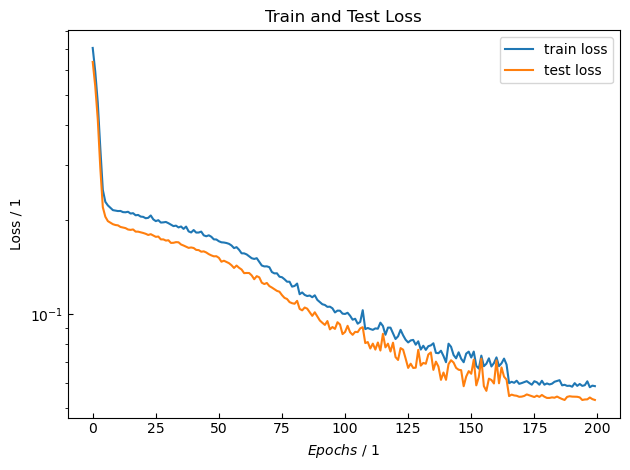

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_015.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.991977990980573 , R^2(NH3) = 0.9780443455440572
Test Dataset: R^2(H2) = 0.9956681303262958 , R^2(NH3) = 0.9892644456857099
Max Error Training: |x_H2 - x_H2,pred| = 0.11963732819284167 , |x_NH3 - x_NH3,pred| = 0.12088917189107248
Max Error Test: |x_H2 - x_H2,pred| = 0.04682164988623838 , |x_NH3 - x_NH3,pred| = 0.05247823355516801


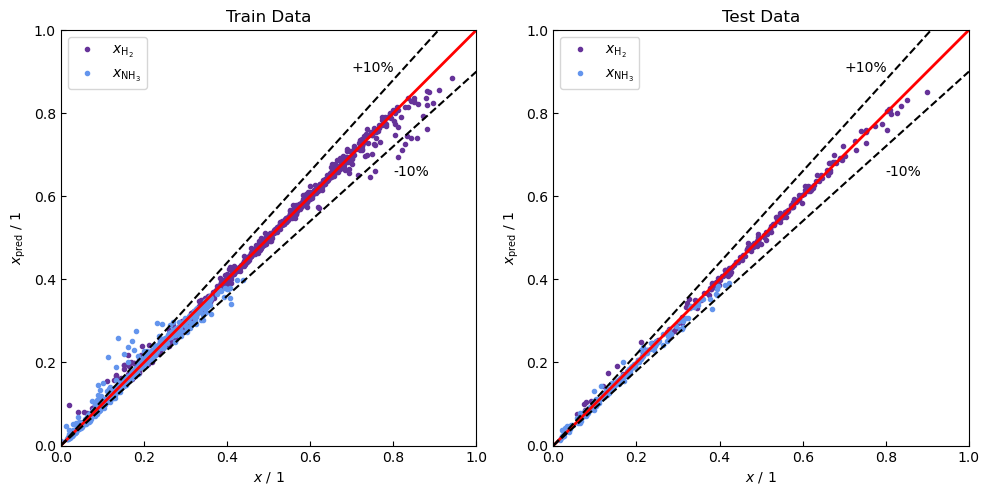

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

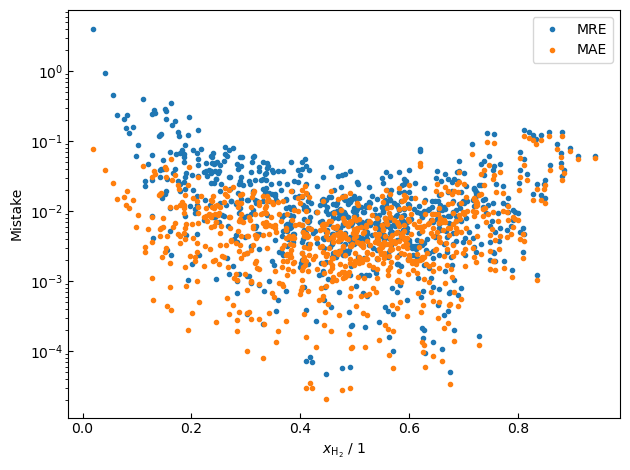

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

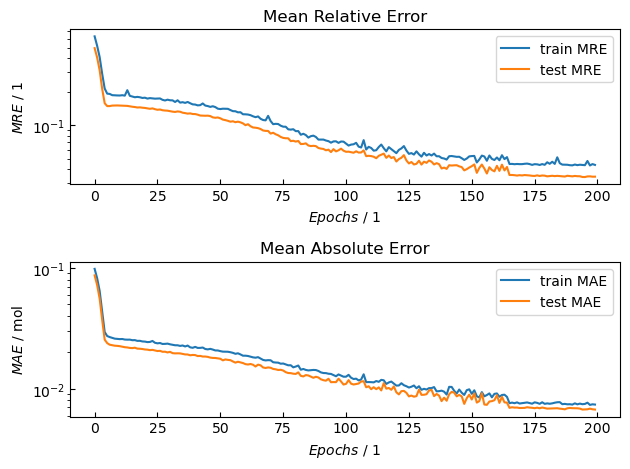

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

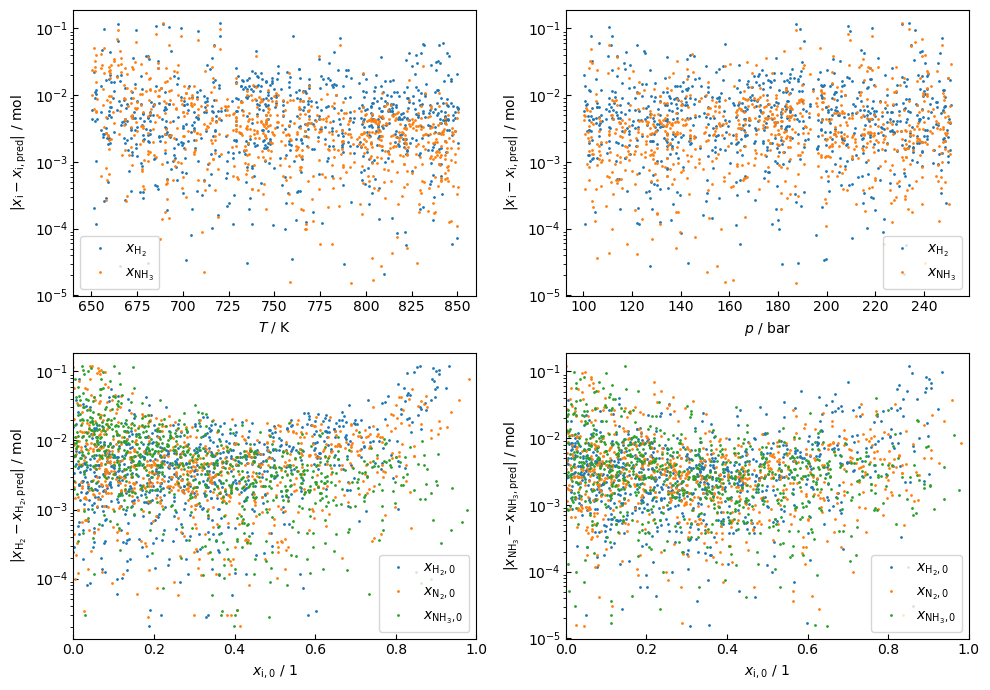

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

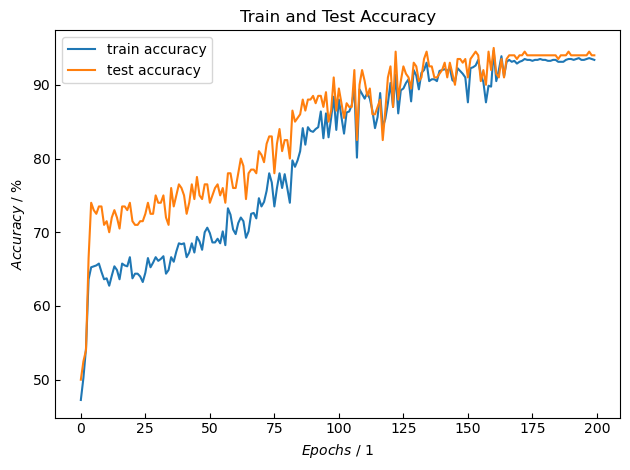

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.6128, -0.1040,  1.0120, -0.1615, -0.8281],
        [ 0.8195, -1.0486, -0.9871,  0.0787,  0.8883],
        [ 0.7534,  0.2113, -0.5100,  0.4256,  0.0655],
        [ 1.5271, -1.7150,  1.0885,  0.2469, -1.3205],
        [ 0.5022, -0.0502,  1.1812, -1.1257, -0.0087],
        [ 1.2959,  0.3613,  1.6449, -1.1078, -0.4820],
        [ 1.0343, -0.2716, -0.8249, -0.7595,  1.5858],
        [-0.0330,  1.4305,  1.1346, -1.0675, -0.0224],
        [ 1.1368,  0.7164, -1.3729, -1.0466,  2.4171],
        [-1.6483, -1.3952,  0.5535,  0.5235, -1.0783],
        [ 1.5276,  0.1648, -0.0329, -0.7492,  0.7981],
        [ 0.5569,  0.1432,  1.0718,  0.2307, -1.2876],
        [-0.3468,  0.0643,  0.0356,  0.7220, -0.7729],
        [-1.2142,  0.3132, -1.1855,  1.9190, -0.7980],
        [ 0.9347,  0.1857, -1.0135,  1.3048, -0.3389],
        [ 0.9248,  1.6671, -0.4233,  1.4710, -1.0881],
        [-0.3442,  0.2931, -0.5032,  0.1984,  0.2910],
        [-0.9382,  0.1907,  0.4247, -0.6121,  0.2089],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.0010,  0.1079,  0.2124,  0.0564,  0.0911],
         [ 0.0230, -0.4116,  0.3625,  0.3570, -0.3032],
         [-0.1403, -0.2993, -0.3812, -0.0520,  0.3980],
         [-0.0671,  0.2855,  0.0134, -0.3342,  0.0531],
         [ 0.4082,  0.3819,  0.0088,  0.1881, -0.2414],
         [-0.2702,  0.0907,  0.3573,  0.0067, -0.3355],
         [ 0.0114, -0.1669, -0.3353,  0.0738, -0.2040],
         [-0.2065,  0.4054, -0.3806,  0.2408, -0.1682],
         [ 0.4794,  0.0282,  0.4129, -0.3234,  0.3749],
         [ 0.2972, -0.4077,  0.3655,  0.2780, -0.3804],
         [-0.2699, -0.0790,  0.0494,  0.4372, -0.0659],
         [-0.0511, -0.3573,  0.2157,  0.4046,  0.0024],
         [-0.2965, -0.0185, -0.0395,  0.2816, -0.1859],
         [-0.2535,  0.0576, -0.0904,  0.2036, -0.2208],
         [-0.3584,  0.0722,  0.2626, -0.3714, -0.2068],
         [ 0.4089,  0.4097, -0.0662,  0.1320,  0.2857],
         [ 0.1575, -0.1500, -0.3784,  0.0303, -0.0124],
         [ 0.4256, -0.327

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4033, 0.4954, 0.2060, 0.5104, 0.4131],
        [0.9941, 0.4561, 0.2194, 0.4482, 0.4651]])
tensor([[ 0.0691, -0.2072],
        [ 0.2758, -0.5509]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.1362e+00, -1.1689e+00, -5.0226e-01,  3.1843e-01,  1.6746e-01],
        [ 1.5271e-01,  5.4699e-01, -5.1319e-01, -3.0325e-01,  8.1358e-01],
        [ 1.1428e+00,  6.0827e-01,  3.7871e-02, -5.3177e-01,  5.0634e-01],
        [-9.2755e-01,  4.7059e-01, -9.4356e-01,  9.3635e-02,  8.3029e-01],
        [-3.5059e-01, -3.5045e-02, -6.4317e-03, -3.6549e-01,  3.7987e-01],
        [-1.0988e+00,  3.3980e-01,  1.9629e+00, -7.2544e-01, -1.1849e+00],
        [ 1.1556e+00, -8.4904e-01, -2.9665e-01,  8.4680e-01, -5.7436e-01],
        [-9.0842e-01, -1.2030e+00,  1.6249e+00, -5.6415e-01, -1.0180e+00],
        [-1.9553e-01,  1.6879e+00,  6.1076e-02, -1.1391e+00,  1.1043e+00],
        [ 1.5524e+00,  1.6091e+00,  2.9793e-01,  1.0719e+00, -1.3880e+00],
        [-1.6567e+00,  3.3916e-01, -2.7547e-02,  9.2913e-02, -6.7929e-02],
        [ 3.1401e-01,  9.6992e-01, -1.0414e+00, -7.6595e-01,  1.8049e+00],
        [ 5.4325e-01,  1.6653e+00, -6.7428e-01,  1.5499e+00, -9.2243e-01],
        [-9.9083e-01, -1.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()